In [41]:
import time
import json
from typing import List, Dict, Tuple, Optional
from src.helpers import run_with_mahi_settings, get_open_udp_port
from src.senders import Sender
from src.strategies import SenderStrategy, FixedWindowStrategy, TahoeStrategy, CubicStrategy

In [183]:
import mpld3

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

from operator import itemgetter
mpld3.enable_notebook()

In [184]:
config = {
    "n_layers": 1,
    "hidden_dim": 15,
    "rdropout": .5, 
    "input_dim": 3,
    "output_dim": 5,
    "batch_size": 1,
}

class LSTM_DQN(nn.Module):
    def __init__(self, config):
        super(LSTM_DQN,self).__init__()
        """
        self.h0 = Variable(torch.zeros(config["batch_size"], 2*config["n_layers"], config["hidden_dim"]//2))
        self.c0 = Variable(torch.zeros(config["batch_size"], 2*config["n_layers"], config["hidden_dim"]//2))
        self.W = nn.LSTM(config["input_dim"], config["hidden_dim"]//2,
                              num_layers=config["n_layers"],
                              dropout=config["rdropout"],
                              bidirectional=True,
                              batch_first=True,
                             )
        """
        self.W = nn.LSTM(config["input_dim"], config["hidden_dim"],batch_first=True)
        self.h0, self.c0 = (torch.zeros(1, 1, config["hidden_dim"]),
                torch.zeros(1, 1, config["hidden_dim"]))
        self.U = nn.Linear(config["hidden_dim"],config["output_dim"])
        
        ## look into initialization strategies                
        for param in self.W.parameters():
            if len(param.size()) > 1:
                nn.init.orthogonal(param)
                
        for param in self.U.parameters():
            if len(param.size()) > 1:
                nn.init.orthogonal(param)
    
    def forward(self, x):
        # apply LSTM
        batch_len, _, _ = x.size()
        
        h0 = self.h0.repeat(1, batch_len, 1)
        c0 = self.c0.repeat(1, batch_len, 1)
        
        out, _ = self.W(x, (h0,c0))

        return self.U(out[:,-1,:])

# What is the shape of X? (batch_size, sequence/history length, num_features)
# How to get the last hidden state produced by nn.LSTM? slice using [:,-1,:] (assuming batch_first=True)
# How to initialize multi-layer, bidirectional LSTMs?
# What is an appropriate way to initialize weights in a reinforcement context? Still orthonormal?
 

In [185]:
state = [{'cwnd': 1, 'rtt': 0.30005860328674316, 'dropped_packet': False, 'seq_num': 0}, {'cwnd': 2, 'rtt': 0.29770970344543457, 'dropped_packet': False, 'seq_num': 1}, {'cwnd': 2, 'rtt': 0.29784488677978516, 'dropped_packet': False, 'seq_num': 2}, {'cwnd': 4, 'rtt': 0.29936742782592773, 'dropped_packet': False, 'seq_num': 3}, {'cwnd': 4, 'rtt': 0.29991865158081055, 'dropped_packet': False, 'seq_num': 4}, {'cwnd': 4, 'rtt': 0.3005836009979248, 'dropped_packet': False, 'seq_num': 5}, {'cwnd': 4, 'rtt': 0.30102968215942383, 'dropped_packet': False, 'seq_num': 6}, {'cwnd': 8, 'rtt': 0.2965514659881592, 'dropped_packet': False, 'seq_num': 7}, {'cwnd': 8, 'rtt': 0.2973325252532959, 'dropped_packet': False, 'seq_num': 8}, {'cwnd': 8, 'rtt': 0.2977468967437744, 'dropped_packet': False, 'seq_num': 9}]

for elem in state:
    if elem["dropped_packet"]:
        elem["dropped_packet"] = 1
    else:
        elem["dropped_packet"] = 0

print(state)

features = ["cwnd", "rtt", "dropped_packet"]



[{'cwnd': 1, 'rtt': 0.30005860328674316, 'dropped_packet': 0, 'seq_num': 0}, {'cwnd': 2, 'rtt': 0.29770970344543457, 'dropped_packet': 0, 'seq_num': 1}, {'cwnd': 2, 'rtt': 0.29784488677978516, 'dropped_packet': 0, 'seq_num': 2}, {'cwnd': 4, 'rtt': 0.29936742782592773, 'dropped_packet': 0, 'seq_num': 3}, {'cwnd': 4, 'rtt': 0.29991865158081055, 'dropped_packet': 0, 'seq_num': 4}, {'cwnd': 4, 'rtt': 0.3005836009979248, 'dropped_packet': 0, 'seq_num': 5}, {'cwnd': 4, 'rtt': 0.30102968215942383, 'dropped_packet': 0, 'seq_num': 6}, {'cwnd': 8, 'rtt': 0.2965514659881592, 'dropped_packet': 0, 'seq_num': 7}, {'cwnd': 8, 'rtt': 0.2973325252532959, 'dropped_packet': 0, 'seq_num': 8}, {'cwnd': 8, 'rtt': 0.2977468967437744, 'dropped_packet': 0, 'seq_num': 9}]


In [186]:
# turn state in to a tensor!
x = torch.Tensor([ [[ elem[feature] for feature in features ] for elem in state ] ,
                   [[ elem[feature] for feature in features ] for elem in state ]  ])

model = LSTM_DQN(config)

#print("x.size()", x.size())

model(x)



/home/vagrant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/home/vagrant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.


tensor([[0.2904, 0.3994, 0.0816, 0.2814, 0.0060],
        [0.2904, 0.3994, 0.0816, 0.2814, 0.0060]], grad_fn=<ThAddmmBackward>)

In [197]:
DEFAULT_TIMEOUT = 2
BETA_CUBIC = 0.7

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

Actions = {
    'INCREASE_PERCENT': 0,
    'DECREASE_PERCENT': 1,
    'INCREASE_ABSOLUTE': 2,
    'DECREASE_ABSOLUTE': 3,
    'STAY': 4
}

ABSOLUTE_CHANGE = 5
PERCENT_CHANGE = 0.1

Rewards = {
    'DROPPED_PACKET': -100,
    'INCREASED_RTT': -70,
    'INCREASED_CWND_ABSOLUTE': 5,
    'INCREASED_CWND_PERCENTAGE': 10,
    'NO_REWARD': 0
}
RTT_CHANGE_THRESHOLD = 1.2
RTT_AVERAGE_WINDOW = 10
BATCH_SIZE = 30
GAMMA = 0.992
STATE_WINDOW_SIZE = 100
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200

class ReinforcementStrategy(SenderStrategy):
    def __init__(self, slow_start_thresh: int, initial_cwnd: int, config: Dict) -> None:
        self.slow_start_thresh = slow_start_thresh

        self.cwnd = initial_cwnd
        self.fast_retransmit_packet = None
        self.time_since_retransmit = None
        self.retransmitting_packet = False
        self.ack_count = 0
        self.timeout = DEFAULT_TIMEOUT
        self.fast_retransmitted_packets_in_flight = []

        self.duplicated_ack = None
        self.slow_start_thresholds = []
        
        self.next_packet_rewards = {} # Mapping of sequence number to action/state combination

        self.sequence_history_dict = {} # list with some fixed size
        self.transitions = []

        self.rtt_average = None
        self.policy_net = LSTM_DQN(config)
        self.target_net = LSTM_DQN(config)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.RMSprop(self.policy_net.parameters())
        
        self.config = config
        super().__init__()

    def select_next_action(self, state: torch.tensor):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * self.seq_num / EPS_DECAY)
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state.unsqueeze(0)).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.config['output_dim'])]], dtype=torch.long)

        
    def window_is_open(self) -> bool:
        # next_ack is the sequence number of the next acknowledgement
        # we are expecting to receive. If the gap between next_ack and
        # seq_num is greater than the window, then we need to wait for
        # more acknowledgements to come in.
        return self.seq_num - self.next_ack < self.cwnd

    def next_packet_to_send(self) -> Optional[str]:
        send_data = None
        in_greater_than_one_retransmit = False
        if self.retransmitting_packet and self.time_of_retransmit and time.time() - self.time_of_retransmit > self.timeout:
            # The retransmit packet timed out--resend it
            self.retransmitting_packet = False
            in_greater_than_one_retransmit = True

        if self.fast_retransmit_packet and not self.retransmitting_packet:
            # Logic for resending the packet
            self.unacknowledged_packets[self.fast_retransmit_packet['seq_num']]['send_ts'] = time.time()
            send_data = self.fast_retransmit_packet
            send_data['is_retransmit'] = True
            serialized_data = json.dumps(send_data)
            self.retransmitting_packet = True
            self.time_of_retransmit = time.time()

        elif self.window_is_open():
            send_data = {
                'seq_num': self.seq_num,
                'send_ts': time.time(),
                'cwnd': self.cwnd,
                'is_retransmit': False
            }

            self.unacknowledged_packets[self.seq_num] = send_data
            self.seq_num += 1
        elif not self.fast_retransmit_packet:
            # Check to see if any segments have timed out. Note that this
            # isn't how TCP actually works--traditional TCP uses exponential
            # backoff for computing the timeouts
            for seq_num, segment in self.unacknowledged_packets.items():
                if seq_num < self.seq_num and time.time() - segment['send_ts'] > self.timeout:
                    print("packet timed out")
                    segment['send_ts'] = time.time()
                    segment['is_retransmit'] = True
                    self.slow_start_thresh = int(max(1, self.cwnd/2))
                    self.cwnd = 1
                    
                    # Update reinforcement learning based on previous window size increase

                    self.fast_retransmitted_packets_in_flight.append(seq_num)
                    self.fast_retransmit_packet = segment
                    self.sequence_history_dict[seq_num] = {
                        'cwnd': segment['cwnd'],
                        'rtt': 0,
                        'dropped_packet': True
                    }
                    self.update_q_function(seq_num, 0, True)
                    return json.dumps(segment)

        if send_data is None:
            return None
        else:
            return json.dumps(send_data)


    def process_ack(self, serialized_ack: str) -> None:
        ack = json.loads(serialized_ack)
        if ack.get('handshake'):
            return

        self.total_acks += 1
        self.times_of_acknowledgements.append(((time.time() - self.start_time), ack['seq_num']))

        if self.unacknowledged_packets.get(ack['seq_num']) is None:
            # Duplicate ack
            #print("received dup ack")
            self.num_duplicate_acks += 1
            if self.duplicated_ack and ack['seq_num'] == self.duplicated_ack['seq_num']:
                self.curr_duplicate_acks += 1
            else:
                self.duplicated_ack = ack
                self.curr_duplicate_acks = 1

            if self.curr_duplicate_acks == 3 and (ack['seq_num'] + 1) not in self.fast_retransmitted_packets_in_flight:
                # Received 3 duplicate acks, retransmit
                print("received 3 dup acks")
                self.fast_retransmitted_packets_in_flight.append(ack['seq_num'] + 1)
                self.fast_retransmit_packet = self.unacknowledged_packets[ack['seq_num'] + 1]
                self.slow_start_thresh = int(max(1, self.cwnd/2))
                
                self.sequence_history_dict[ack['seq_num']] = {
                    'cwnd': ack['cwnd'],
                    'rtt': 0,
                    'dropped_packet': True
                }
                self.update_q_function(ack['seq_num'], 0, True)
                # Update reinforcement learning based on previous window size increase
                self.cwnd = 1
        elif ack['seq_num'] >= self.next_ack:
            if self.fast_retransmit_packet is not None:
                self.fast_retransmit_packet = None
                self.retransmitting_packet = False
                self.curr_duplicate_acks = 0
                self.seq_num = ack['seq_num'] + 1

                self.fast_retransmitted_packets_in_flight = []

            # Acknowledge all packets where seq_num < ack['seq_num']
            self.unacknowledged_packets = {
                k:v
                for k,v in
                self.unacknowledged_packets.items()
                if k > ack['seq_num']
            }
            self.next_ack = max(self.next_ack, ack['seq_num'] + 1)
            self.seq_num = self.next_ack
            self.ack_count += 1
            self.sent_bytes = ack['ack_bytes']
            rtt = float(time.time() - ack['send_ts'])
            self.rtts.append(rtt)
            self.rtt_recordings.append((time.time(), rtt))

            if self.rtt_average is None:
                self.rtt_average = rtt
            else:
                self.rtt_average = sum(self.rtts[-RTT_AVERAGE_WINDOW:])/len(self.rtts[-RTT_AVERAGE_WINDOW:])
            
            
            self.timeout = rtt * 1.2
            
            self.sequence_history_dict[ack['seq_num']] = {
                'cwnd': ack['cwnd'],
                'rtt': rtt,
                'dropped_packet': False,
                'seq_num': ack['seq_num']
            }
            
            current_state = self.compute_state(max(ack['seq_num'] - STATE_WINDOW_SIZE, 0), ack['seq_num'])
            current_state = self.state_to_tensor(current_state)

            current_action = self.select_next_action(current_state)
                        
            self.update_cwnd(current_action)
            
            
#             if self.cwnd < self.slow_start_thresh:
#                 # In slow start
#                 self.cwnd += 1
#             elif (ack['seq_num'] + 1):
#                 # In congestion avoidance
#                 self.cwnd += 1.0/self.cwnd
            # TODO: Move to other function
            if len(self.unacknowledged_packets.keys()) == 0:
                reward_packet = int(self.cwnd) + ack['seq_num']
                #print("NO UNACKNOWLEDGED PACKETS")
            else:
                reward_packet =  (int(self.cwnd) - len(self.unacknowledged_packets)) + max(self.unacknowledged_packets.keys())

                
           # current_action = Actions['INCREASE_PERCENT']
            
            self.next_packet_rewards[reward_packet] = (
                (max(ack['seq_num'] - STATE_WINDOW_SIZE, 0), ack['seq_num']),
                self.rtt_average,
                torch.tensor([int(current_action)], dtype=torch.long)
            )
#             print("reward packet %d" % reward_packet)
#             print("getting ack for %d" % ack['seq_num'])
            
            self.update_q_function(ack['seq_num'], rtt)

        self.cwnds.append((time.time(), self.cwnd))
        self.slow_start_thresholds.append((time.time(), self.slow_start_thresh))
 
    def state_to_tensor(self, state: List) -> torch.Tensor:
        current_state = [[ elem[feature] for feature in features ] for elem in state ]
        pad = [ [0.0]*self.config["input_dim"] ]*(STATE_WINDOW_SIZE-len(current_state)) 
        current_state = pad + current_state
        return torch.Tensor(current_state)


    def update_cwnd(self, action: int):
        if action == Actions['INCREASE_PERCENT']:
            self.cwnd = self.cwnd * (1 + PERCENT_CHANGE)
        elif action == Actions['INCREASE_ABSOLUTE']:
            self.cwnd = self.cwnd + ABSOLUTE_CHANGE
        elif action == Actions['DECREASE_PERCENT']:
            self.cwnd = max(self.cwnd * (1 - PERCENT_CHANGE), 1)
        elif action == Actions['DECREASE_ABSOLUTE']:
            self.cwnd = max(self.cwnd - ABSOLUTE_CHANGE, 1)
        elif action == Actions['STAY']:
            self.cwnd = self.cwnd
    
    def optimize_model(self):
        if (len(self.transitions)  < BATCH_SIZE):
            return
        

        transitions = random.sample(self.transitions, BATCH_SIZE)
        batch = Transition(*zip(*transitions))
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        
        predicted_actions = self.policy_net(state_batch)
        
        state_action_values = predicted_actions.gather(1, action_batch.unsqueeze(-1))
        
        next_state_values = self.target_net(state_batch).max(1)[0].detach()
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
    
    def update_q_function(self, seq_num: int, rtt: float = None, dropped_packet: bool = False):
        # Update Q Function
        if dropped_packet:
            print("dropped packet & updating q function %d" % seq_num)
            print(self.next_packet_rewards)
        if self.next_packet_rewards.get(seq_num):
            """In this function, we can now construct state, reward & next state, and add to the Q function"""
            sequence_range, previous_average_rtt, action = self.next_packet_rewards.get(seq_num)

            if dropped_packet:
                rtt = 0
                print("WE DROPPED A PACKET")
                print(action)
                print(sequence_range)
                print(previous_average_rtt)
            state = self.compute_state(*sequence_range)
            next_state = self.compute_state(max(seq_num - STATE_WINDOW_SIZE, 0), seq_num)

            reward = self.compute_reward(rtt, previous_average_rtt, action, dropped_packet)

            self.transitions.append(
                Transition(
                    self.state_to_tensor(state).unsqueeze(0),
                    action,
                    self.state_to_tensor(next_state).unsqueeze(0),
                    torch.Tensor([reward])
                )
            )
            self.optimize_model()

            del self.next_packet_rewards[seq_num]
        
    def compute_state(self, begin: int, end: int) -> List[Dict]:
        return list(list(zip(*sorted([(seq_num, state)
            for seq_num, state in self.sequence_history_dict.items()
            if seq_num >= begin and seq_num <= end], key=itemgetter(0))[-100:]))[1])
        
    def compute_reward(self, rtt: float, previous_average_rtt: float, action: int, dropped_packet: bool):
        
        if dropped_packet:
            return Rewards['DROPPED_PACKET']
        
        elif (rtt/previous_average_rtt) > RTT_CHANGE_THRESHOLD:
            return Rewards['INCREASED_RTT']
        
        elif action == Actions['INCREASE_PERCENT']:
            return Rewards['INCREASED_CWND_PERCENTAGE']
        elif action == Actions['INCREASE_ABSOLUTE']:
            return Rewards['INCREASED_CWND_ABSOLUTE']
        else:
            return Rewards['NO_REWARD']
        
        
        

/home/vagrant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/home/vagrant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.


[sender] Connected to receiver: 100.64.0.2:50501

packet timed out
dropped packet & updating q function 17
{17: ((0, 16), 0.3410116910934448, tensor([1]))}
WE DROPPED A PACKET
tensor([1])
(0, 16)
0.3410116910934448
received 3 dup acks
dropped packet & updating q function 484
{485: ((63, 163), 0.8880070686340332, tensor([0])), 518: ((64, 164), 0.9148194074630738, tensor([0])), 555: ((65, 165), 0.9415828943252563, tensor([0])), 595: ((66, 166), 0.9749866724014282, tensor([0])), 639: ((67, 167), 0.9982727766036987, tensor([0])), 645: ((68, 168), 1.0215725660324098, tensor([2])), 598: ((69, 169), 1.0437552452087402, tensor([1])), 604: ((70, 170), 1.064777636528015, tensor([2])), 648: ((71, 171), 1.0840658664703369, tensor([0])), 697: ((72, 172), 1.1044904947280885, tensor([0])), 751: ((73, 173), 1.126044225692749, tensor([0])), 810: ((74, 174), 1.147654414176941, tensor([0])), 747: ((75, 175), 1.169326376914978, tensor([1])), 748: ((76, 176), 1.1901312589645385, tensor([4])), 806: ((77, 17

Results for sender 43854, with strategy: ReinforcementStrategy
**Throughput:**                           897.333333 bytes/s
**Average RTT:**                          2088.188204 ms



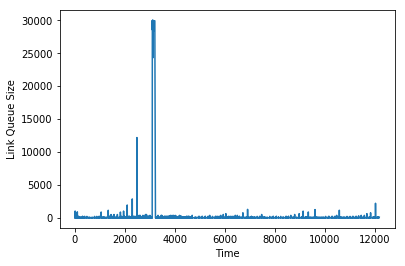

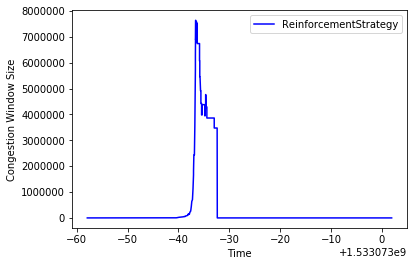

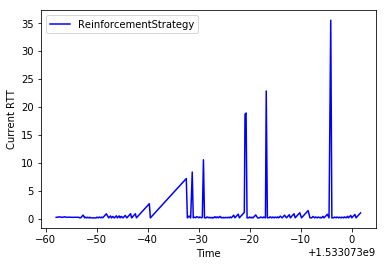

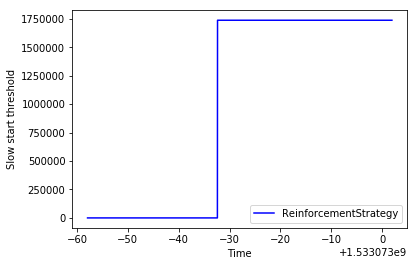

In [198]:
mahimahi_settings = {
    'delay': 88,
    'trace_file': '2.64mbps-poisson.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 30000
    }
}
port = get_open_udp_port()
strat = ReinforcementStrategy(10, 1, config)
run_with_mahi_settings(mahimahi_settings, 60, [Sender(port, strat)])